In [ ]:
from google.colab import drive

In [ ]:
drive.mount('drive', force_remount=True)

Mounted at drive


In [ ]:
import os

In [ ]:
import numpy as np
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as mplot
import tensorflow_addons as tfa


In [ ]:
from tensorflow import pad
from tensorflow.keras.layers import Layer

'''
  2D Reflection Padding
  Attributes:
    - padding: (padding_width, padding_height) tuple
'''
class ReflectionPadding2D(Layer):
    def __init__(self, padding=(1, 1), **kwargs):
        self.padding = tuple(padding)
        super(ReflectionPadding2D, self).__init__(**kwargs)

    def compute_output_shape(self, input_shape):
        return (input_shape[0], input_shape[1] + 2 * self.padding[0], input_shape[2] + 2 * self.padding[1], input_shape[3])

    def call(self, input_tensor, mask=None):
        padding_width, padding_height = self.padding
        return pad(input_tensor, [[0,0], [padding_height, padding_height], [padding_width, padding_width], [0,0] ], 'REFLECT')

In [ ]:
'''
  define essential variables for the script
'''

path = 'drive/My Drive/Colab Notebooks/cycle_GAN/data/'
current_path = 'drive/My Drive/Colab Notebooks/cycle_GAN/'
model_path = current_path + '/models/model_2'
loss_path = os.path.join(current_path, 'losses/loss_model_2')
mplot.figure(figsize=(12,12))

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

In [ ]:
monet_path = path + os.listdir(path)[0]+'/'
reg_path = path + os.listdir(path)[2]+'/'

In [ ]:
os.listdir(loss_path)

['loss_5_1.csv', 'loss_5_2.csv', 'loss_5_3.csv', 'loss_5_4.csv']

In [ ]:
!cp 'drive/My Drive/Colab Notebooks/cycle_GAN/gan_load.py' .

In [ ]:
from gan_load import file_load

In [ ]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  try:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
    print(e)

1 Physical GPUs, 1 Logical GPUs


In [ ]:
reg_path

'drive/My Drive/Colab Notebooks/cycle_GAN/data/photo_jpg_test/'

In [ ]:
file_loader = file_load()

In [ ]:
monet_img = file_loader.get_img(monet_path)

In [ ]:
reg_img = file_loader.get_img(reg_path)

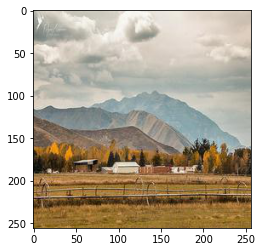

In [ ]:
mplot.imshow(reg_img[np.random.randint(0,300)])

### Preprocess the image

1) Convert them to -1 to 1 scale

2) Convert them to tensor

3) Random Crop

4) random flip

In [ ]:
def pre_processing_img(img):
  img = (img*2) - 1

  img = tf.image.resize(img, [286,286], method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)

  img = tf.image.random_crop(img, size=[256,256,3])

  img = tf.image.random_flip_left_right(img)

  return img


### Create Dataset iterators
Creat tensorflow.data.Dataset API for input pipeline

In [ ]:
def make_iterator(img_array, batch_size):
  img_iterator = tf.data.Dataset.from_tensor_slices(img_array)
  img_iterator = img_iterator.map(pre_processing_img).batch(batch_size)
  return img_iterator

In [ ]:
monet_iterator = make_iterator(monet_img, 1)
regular_iterator = make_iterator(reg_img, 1)

In [ ]:
sample_regular = next(iter(regular_iterator))

##Define Network
Define all the components of the GAN

1) Downscale Generator

2) Resnet

3) Upscale Generator

4) PatchGAN Discriminator

In [ ]:
from tensorflow.keras.layers import Input, Conv2D, Activation,Add, LeakyReLU, Conv2DTranspose
from tensorflow.keras.models import Model


In [ ]:
def pre_convolutional_block(input_layer):
    gaussian = tf.random_normal_initializer(0,0.02)


    x = ReflectionPadding2D((3,3), name='Ref_first')(input_layer)
    
    x = Conv2D(filters=64, padding='valid', kernel_size=(7,7), strides=(1,1), kernel_initializer=gaussian, name='conv1_pre')(x)
    x = tfa.layers.InstanceNormalization(axis=-1)(x)
    x = Activation('relu')(x)
    
    x = Conv2D(filters=128, padding='same', kernel_size=(3,3), strides=(2,2), kernel_initializer=gaussian, name='conv2_pre')(x)
    x = tfa.layers.InstanceNormalization(axis=-1)(x)
    x = Activation('relu')(x)
    
    x = Conv2D(filters=256, padding='same', kernel_size=(3,3), strides=(2,2), kernel_initializer=gaussian, name='conv3_pre')(x)
    x = tfa.layers.InstanceNormalization(axis=-1)(x)
    x = Activation('relu')(x)
    
    return x

    

In [ ]:
def R256(input_layer, res_position, f=256, k=(3,3), s=(1,1)):
    gaussian = tf.random_normal_initializer(0,0.02)
    
    x = ReflectionPadding2D((1,1))(input_layer)

    x = Conv2D(filters=f, kernel_size=k, padding='valid', strides=s, name='res'+str(res_position)+'a', kernel_initializer=gaussian)(x)
    x = tfa.layers.InstanceNormalization(axis=-1)(x)
    x = Activation('relu')(x)

    x = ReflectionPadding2D((1,1))(x)
    
    x = Conv2D(filters=f, kernel_size=k, padding='valid', strides=s, name='res'+str(res_position)+'b', kernel_initializer=gaussian)(x)
    x = tfa.layers.InstanceNormalization(axis=-1)(x)
    
    x = Add(name = 'res'+str(res_position)+'final')([input_layer, x])
    
    return x
    
    

In [ ]:
def post_convolutional_block(input_layer):
    gaussian = tf.random_normal_initializer(0,0.02)
    
    x = Conv2DTranspose(filters=128, kernel_size=(3,3), padding='same', strides=(2, 2), kernel_initializer=gaussian, name='conv1_post')(input_layer)
    x = tfa.layers.InstanceNormalization(axis=-1)(x)
    x = Activation('relu')(x)
    
    x = Conv2DTranspose(filters=64, kernel_size=(3,3), padding='same', strides=(2, 2), kernel_initializer=gaussian, name='conv2_post')(x)
    x = tfa.layers.InstanceNormalization(axis=-1)(x)
    x = Activation('relu')(x)

    x = ReflectionPadding2D(padding=(3,3), name='Ref_last')(x)
    
    x = Conv2D(filters=3, kernel_size=(7,7), padding='valid', strides=(1, 1), kernel_initializer=gaussian, name='conv3_post')(x)
    x = Activation('tanh', name='tanh_activation')(x)
    
    return x

In [ ]:
def make_generator(input_shape, name='generator_model'):
    
    input_layer = Input(input_shape)
    x = pre_convolutional_block(input_layer)
    x = R256(x, 1)
    x = R256(x,2)
    x = R256(x,3)
    x = R256(x, 4)
    x = R256(x,5)
    x = R256(x,6)
    x = R256(x, 7)
    x = R256(x,8)
    x = R256(x,9)
    x = post_convolutional_block(x)
    
    model = Model(inputs=input_layer, outputs=x, name=name)
    return model

In [ ]:
monet_shape = monet_img[0].shape
regular_shape = reg_img[0].shape

In [ ]:
generator_M = make_generator(regular_shape, name='regular_to_monet_generator')

In [ ]:
generator_R = make_generator(monet_shape, name = 'monet_to_regular_generator')

In [ ]:
generator_M.summary()

Model: "regular_to_monet_generator"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
Ref_first (ReflectionPadding2D) (None, 262, 262, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_pre (Conv2D)              (None, 256, 256, 64) 9472        Ref_first[0][0]                  
__________________________________________________________________________________________________
instance_normalization (Instanc (None, 256, 256, 64) 128         conv1_pre[0][0]                  
_________________________________________________________________________

In [ ]:
generator_R.summary()

Model: "monet_to_regular_generator"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
Ref_first (ReflectionPadding2D) (None, 262, 262, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1_pre (Conv2D)              (None, 256, 256, 64) 9472        Ref_first[0][0]                  
__________________________________________________________________________________________________
instance_normalization_23 (Inst (None, 256, 256, 64) 128         conv1_pre[0][0]                  
_________________________________________________________________________

In [ ]:
def make_discriminator(input_shape, name='disc_model'):
    gaussian = tf.random_normal_initializer(0,0.02)
    
    input_layer = Input(input_shape)
    x = Conv2D(filters=64, kernel_size=(4,4), padding='same', strides=(2,2), name='disc_conv_1', kernel_initializer=gaussian)(input_layer)
    x = LeakyReLU(0.2)(x)
    
    x = Conv2D(filters=128, kernel_size=(4,4), padding='same', strides=(2,2), name='disc_conv_2', kernel_initializer=gaussian)(x)
    x = tfa.layers.InstanceNormalization(axis=-1)(x)
    x = LeakyReLU(0.2)(x)
    
    x = Conv2D(filters=256, kernel_size=(4,4), padding='same', strides=(2,2), name='disc_conv_3', kernel_initializer=gaussian)(x)
    x = tfa.layers.InstanceNormalization(axis=-1)(x)
    x = LeakyReLU(0.2)(x)
    
    x = Conv2D(filters=512, kernel_size=(4,4), padding='same', strides=(1,1), name='disc_conv_4', kernel_initializer=gaussian)(x)
    x = tfa.layers.InstanceNormalization(axis=-1)(x)
    x = LeakyReLU(0.2)(x)


    
    x = Conv2D(filters=1, kernel_size=(4,4), padding='same', strides=(1,1), name='disc_conv_final', kernel_initializer=gaussian)(x)

    
    return Model(inputs=input_layer, outputs=x, name = name)
    
    
    

In [ ]:
regular_shape = (256,256,3)
monet_shape  = (256, 256, 3)

discriminator_monet = make_discriminator(regular_shape, name='monet_recognizer')
discriminator_regular = make_discriminator(monet_shape, name='regular_recognizer')

In [ ]:
discriminator_monet.summary()

Model: "monet_recognizer"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 256, 256, 3)]     0         
_________________________________________________________________
disc_conv_1 (Conv2D)         (None, 128, 128, 64)      3136      
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 128, 128, 64)      0         
_________________________________________________________________
disc_conv_2 (Conv2D)         (None, 64, 64, 128)       131200    
_________________________________________________________________
instance_normalization_46 (I (None, 64, 64, 128)       256       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 64, 64, 128)       0         
_________________________________________________________________
disc_conv_3 (Conv2D)         (None, 32, 32, 256)  

In [ ]:
discriminator_regular.summary()

Model: "regular_recognizer"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 256, 256, 3)]     0         
_________________________________________________________________
disc_conv_1 (Conv2D)         (None, 128, 128, 64)      3136      
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 128, 128, 64)      0         
_________________________________________________________________
disc_conv_2 (Conv2D)         (None, 64, 64, 128)       131200    
_________________________________________________________________
instance_normalization_49 (I (None, 64, 64, 128)       256       
_________________________________________________________________
leaky_re_lu_5 (LeakyReLU)    (None, 64, 64, 128)       0         
_________________________________________________________________
disc_conv_3 (Conv2D)         (None, 32, 32, 256)

## Define Loss Functions

### Discriminator loss
The discriminator tries to do two things. It tries to maximize the values obtained from real image and minimize values obtained from fake images.
Therefore it minimizes (1 - real) + (fake - 0)

### Generator loss
The generator tries to maximize the value obtained by discriminator for the fake image. Therefore it minimizes (1-fake)

In [ ]:
#all different losses
bin_loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)
absolute_loss = tf.keras.losses.MeanAbsoluteError()

In [ ]:
def discriminator_loss(real, fake):
    real_loss = bin_loss(tf.ones_like(real), real)
    gen_loss = bin_loss(tf.zeros_like(fake), fake)
    
    disc_loss = (real_loss + gen_loss) * 0.5
    
    return disc_loss

In [ ]:
def generator_loss(fake):
    gen_loss = bin_loss(tf.ones_like(fake), fake)
    
    return gen_loss

In [ ]:
def identity_loss(real, identity_real, weight):
    id_loss = 0.5 * weight * absolute_loss(real, identity_real)
    
    return id_loss

In [ ]:
def cycle_loss(real, cycled, weight):
    cyc_loss =  weight * absolute_loss(real, cycled) 
    
    return cyc_loss

### Define Optimizers
Using Adam Optimizer with learning rate of 0.0002

In [ ]:
#generator that takes real image to monet image
gen_m_opt = tf.keras.optimizers.Adam(0.0002)
#generator that takes monet image to real image
gen_r_opt = tf.keras.optimizers.Adam(0.0002)

#discriminator that classifies monet as True
disc_m_opt = tf.keras.optimizers.Adam(0.0002)
#discriminator that classifies regular images as true
disc_r_opt = tf.keras.optimizers.Adam(0.0002) 

### Generate Samples to track training

Take the same image for input and translate it every few epochs to see progress

In [ ]:
def de_normalize(img):
  img = np.squeeze(img, axis=0)
  img = (img+1)/2
  return img

In [ ]:

def track_progress(epoch=0):
  print('Results for epoch {}'.format(epoch))
  mon_sample_gen = generator_M(sample_regular)
  reg_sample_img = de_normalize(sample_regular)
  mon_sample_gen = de_normalize(mon_sample_gen)
  fig, (ax1, ax2) = mplot.subplots(1,2)
  ax1.imshow(reg_sample_img)
  ax2.imshow(mon_sample_gen)
  mplot.show()



Results for epoch 1


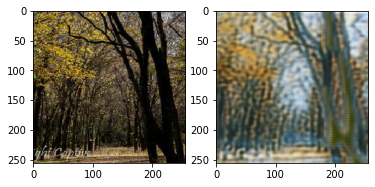

In [ ]:
track_progress(1)

### Checkpoints
Starting a checkpoint and a checkpoint manager to allow training in different intervals.


**Always run before training unless starting from a fresh checkpoint**

In [ ]:
ckpt = tf.train.Checkpoint(generator_M = generator_M, generator_R = generator_R,
                           discriminator_monet = discriminator_monet, discriminator_regular = discriminator_regular,
                           gen_m_opt = gen_m_opt, gen_r_opt=gen_r_opt, disc_m_opt = disc_m_opt, disc_r_opt = disc_r_opt
                           )

ckpt_manager = tf.train.CheckpointManager(ckpt, directory= model_path, max_to_keep=5)



In [ ]:
if ckpt_manager.latest_checkpoint:
  ckpt.restore(ckpt_manager.latest_checkpoint)
  print('Restored', ckpt_manager.latest_checkpoint)

Restored drive/My Drive/Colab Notebooks/cycle_GAN//models/model_2/ckpt-3


In [ ]:
def train_CGAN(t_monet, t_regular, cycle_weight):
    
    with tf.GradientTape(persistent=True) as tape:
        fake_monet = generator_M(t_regular, training=True)
        cycle_regular = generator_R(fake_monet, training=True)

        #turning monet img to  regualr and cycle back to monet
        fake_regular = generator_R(t_monet, training=True)
        cycle_monet = generator_M(fake_regular, training=True)

        #taking a monet and generate monet using monet generator
        identity_monet = generator_M(t_monet, training=True)

        #taking a regular image and generate a regular using regular generator
        identity_regular = generator_R(t_regular, training=True)

        pred_real_monet = discriminator_monet(t_monet, training=True)
        pred_fake_monet = discriminator_monet(fake_monet, training=True)

        pred_real_regular = discriminator_regular(t_regular, training=True)
        pred_fake_regular = discriminator_regular(fake_regular, training=True)

        #discriminator losses
        monet_disc_loss = discriminator_loss(pred_real_monet, pred_fake_monet)
        regular_disc_loss = discriminator_loss(pred_real_regular, pred_fake_regular)

        #identity losses
        monet_identity_loss = identity_loss(t_monet, identity_monet, cycle_weight)
        regular_identity_loss = identity_loss(t_regular, identity_regular, cycle_weight)

        #cyclic loss
        monet_cyclic_loss = cycle_loss(t_monet, cycle_monet, cycle_weight)
        regular_cyclic_loss = cycle_loss(t_regular, cycle_regular, cycle_weight)

        #generator loss
        generator_monet_loss = generator_loss(pred_fake_monet)
        generator_regular_loss = generator_loss(pred_fake_regular)


        total_cyclic_loss = monet_cyclic_loss + regular_cyclic_loss

        #total generator losses
        total_gen_monet_loss = generator_monet_loss + total_cyclic_loss + monet_identity_loss
        total_gen_regular_loss = generator_regular_loss + total_cyclic_loss + regular_identity_loss

    #generator gradients
    gen_monet_gradient = tape.gradient(total_gen_monet_loss, generator_M.trainable_variables)
    gen_regular_gradient = tape.gradient(total_gen_regular_loss, generator_R.trainable_variables)

    #discriminator gradients
    disc_monet_gradient = tape.gradient(monet_disc_loss, discriminator_monet.trainable_variables)
    disc_regular_gradient = tape.gradient(regular_disc_loss, discriminator_regular.trainable_variables)

    #apply gradients to optimizer
    gen_m_opt.apply_gradients(zip(gen_monet_gradient, generator_M.trainable_variables))
    gen_r_opt.apply_gradients(zip(gen_regular_gradient, generator_R.trainable_variables))

    disc_m_opt.apply_gradients(zip(disc_monet_gradient, discriminator_monet.trainable_variables))
    disc_r_opt.apply_gradients(zip(disc_regular_gradient, discriminator_monet.trainable_variables))

    total_losses = total_gen_monet_loss+total_gen_regular_loss + monet_disc_loss + regular_disc_loss         
        
    return {'total_losses':[total_losses], 'monet_disc_loss':[monet_disc_loss], 'regular_disc_loss':[regular_disc_loss], 'monet_gen_loss': [total_gen_monet_loss], 'regular_gen_loss':[total_gen_regular_loss]}      
        

In [ ]:
'''
  Defining pre requisites for the training loop
'''

run=4
epochs = 85
all_losses_list = ['total_losses', 'monet_disc_loss', 'regular_disc_loss', 'monet_gen_loss', 'regular_gen_loss']      
all_losses_df = pd.DataFrame(columns=all_losses_list)
epoch_loss = [] 



Epoch 1:
 Step 290/300 completed	 total_loss:28.013142213983052
Results for epoch 1


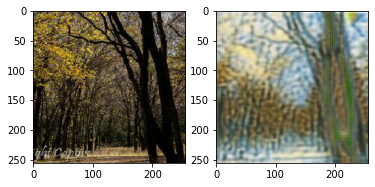

Epoch 2:
 Step 290/300 completed	 total_loss:29.78201469809322
Results for epoch 2


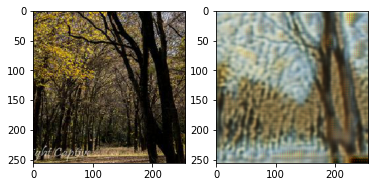

Epoch 3:
 Step 290/300 completed	 total_loss:31.994802701271187
Results for epoch 3


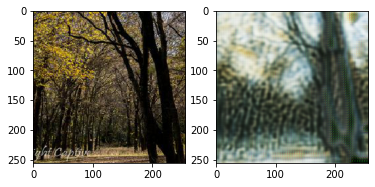

Epoch 4:
 Step 290/300 completed	 total_loss:35.34454780190678
Results for epoch 4


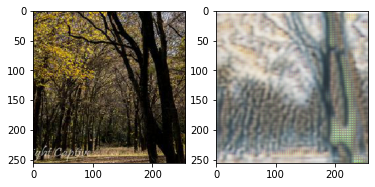

Epoch 5:
 Step 290/300 completed	 total_loss:34.88786414194915
Results for epoch 5


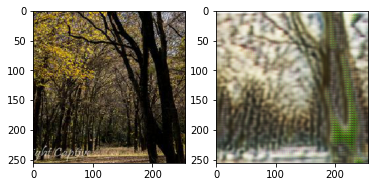

Saved at epoch 4

Epoch 6:
 Step 10/300 completed

KeyboardInterrupt: ignored

In [ ]:

for epoch in range(epochs):
    step_loss = pd.DataFrame(columns = all_losses_list)
    print('Epoch {}:'.format(epoch+1))
    for i, (one_monet, one_regular) in enumerate(zip(monet_iterator, regular_iterator)):
        if((i+1)%10 == 0):
            print('\r','Step {}/300 completed'.format(i+1), end='')
        
        # dictionary returned from my train_CGAN function for one step
        losses = train_CGAN(one_monet, one_regular, 10)

        #dataframe with losses for each step in one epoch
        step_loss = pd.concat([step_loss, pd.DataFrame(losses)], ignore_index=True)

    
    
    #Things to happen every epoch: 1)calculate mean loss 2)append to the all_losses_df
    mean_losses = step_loss.mean()
    #dictionary of mean of all losses for one epoch
    mean_dictionary = {'total_losses': [mean_losses[0]], 'monet_disc_loss':[mean_losses[1]], 'regular_disc_loss':[mean_losses[2]], 'monet_gen_loss': [mean_losses[3]], 'regular_gen_loss':[mean_losses[4]]} 
    #df with mean loss of every epoch
    all_losses_df = pd.concat([all_losses_df, pd.DataFrame(mean_dictionary)], ignore_index=True)     
    
    total_loss = mean_losses['total_losses']

    print('\t total_loss:{}'.format(total_loss))
    
    track_progress(epoch+1)
    # Things to happen each 5 epochs: 1) save checkpoint 2) save loss csv
    if ((epoch+1)%5 == 0):
      all_losses_df.to_csv(loss_path + "/loss_{}_{}.csv".format(epoch+1,run))
      ckpt_manager.save()
      print('Saved at epoch {}'.format(epoch))
      print()
    

### Evaluation
This portion covers the evaluation of the model


In [ ]:
def translate_image(original_img, target_domain):
  if (len(original_img.shape) == 3):
    original_img = np.expand_dims(original_img, axis=0)

  if (target_domain == 'monet'):
    prediction_array = generator_M(original_img)
  elif (target_domain == 'regular'):
    prediction_array = generator_R(original_img)
  
  return prediction_array

In [ ]:
for i in range(1,10):
  test_img = reg_img[np.random.randint(0,300)]
  mplot.imshow(test_img)
  mplot.savefig(current_path+'/'+'regular_{}.png'.format(i))
  mplot.show()
  translated_img = translate_image(test_img, 'monet')
  mplot.imshow(np.squeeze(translated_img))
  mplot.savefig(current_path+'/'+'to_monet_{}.png'.format(i))
  mplot.show()

In [ ]:
ckpt.restore(ckpt_manager.checkpoints[2])

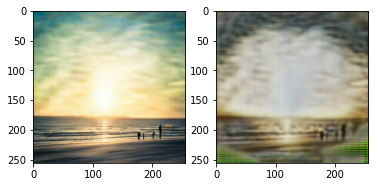

In [ ]:
r_rand = np.random.randint(0,300)
test_1 = translate_image(reg_img[r_rand], 'monet')
fig, (ax1,ax2) = mplot.subplots(1,2)
ax1.imshow(reg_img[r_rand])
ax2.imshow(de_normalize(test_1))


Results for epoch 0


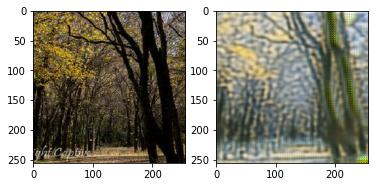

In [ ]:
track_progress()